In [2]:
import os
import time
import glob
import LatLon 
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime
from matplotlib.dates import date2num
pd.set_option('display.max_rows', 10)

%matplotlib inline
import pylab
import geoplotlib
import seaborn as sns
sns.set_style("whitegrid")
from mpl_toolkits import basemap
from pysurvey.plot import setup, legend, icolorbar, density, text
from sklearn import cluster

In [8]:
filename = '/Users/ajmendez/tmp/ships/ships_clean.csv'
shipdata = pd.read_csv(filename)
shipdata = shipdata[shipdata['Lat3'].notnull() & shipdata['Lon3'].notnull() ]
print('Number of records: {:,d}'.format(len(shipdata)))

Number of records: 252,917


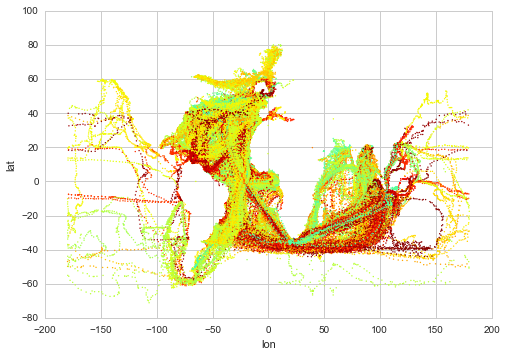

In [9]:
shipdata.plot('lon', 'lat', c='Year', kind='scatter', 
              lw=0, cmap=pylab.cm.jet, s=2, colorbar=False)

In [12]:
lon = np.array(shipdata['lon'])
lat = np.array(shipdata['lat'])
c = np.array(shipdata['Year'])
vmin, vmax = np.percentile(c, (5,95))

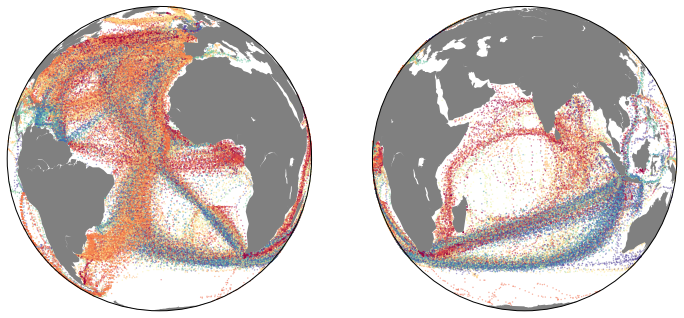

In [14]:
pylab.figure(figsize=(12,6))
pylab.subplot(121)
m = basemap.Basemap(lon_0=-20, projection='geos')
m.fillcontinents(color='0.5')
x, y = m(lon, lat)
sca = m.scatter(x,y, c=c, label='Year',
                vmin=vmin, vmax=vmax, cmap=pylab.cm.Spectral,
                s=2, lw=0, alpha=0.5)

pylab.subplot(122)
m = basemap.Basemap(lon_0=70, projection='geos')
m.fillcontinents(color='0.5')
x, y = m(lon, lat)
sca = m.scatter(x,y, c=c, label='Year',
                vmin=vmin, vmax=vmax, cmap=pylab.cm.Spectral,
                s=2, lw=0, alpha=0.5)
None

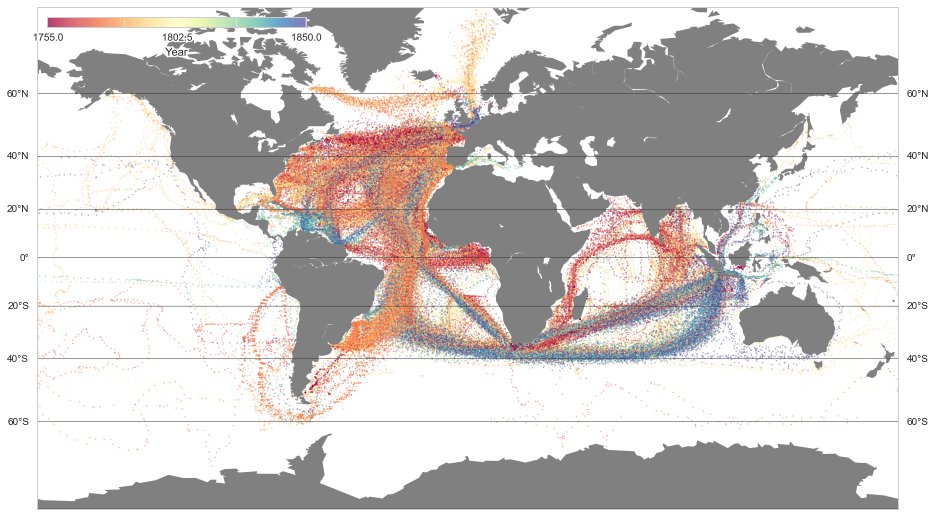

In [16]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)

x, y = m(lon, lat)
sca = m.scatter(x,y, c=c, label='Year',
                vmin=vmin, vmax=vmax, cmap=pylab.cm.Spectral,
                s=2, lw=0, alpha=0.5)
icolorbar(sca)
None

In [17]:
x,y = np.linspace(-180,180,361), np.linspace(-80,80,161)
X,Y = np.meshgrid(x,y)
Z = np.histogram2d(lon, lat, bins=(x,y))[0]
Z = np.ma.MaskedArray(np.log10(Z), Z==0)
# X,Y = np.meshgrid(X,Y)

<matplotlib.colorbar.Colorbar instance at 0x130e53050>

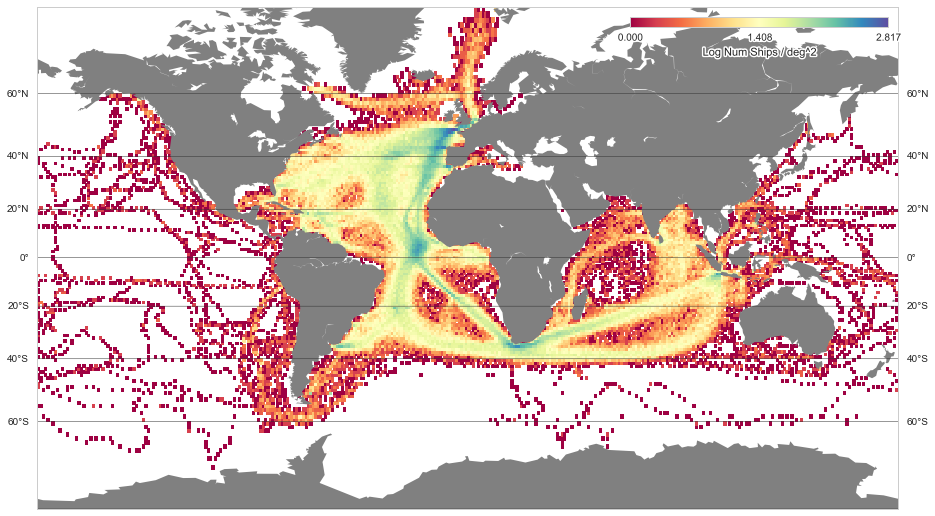

In [18]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80, projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)

mx, my = m(X,Y)
pcm = m.pcolormesh(mx,my, Z.T, label='Log Num Ships / deg^2',
                   cmap=pylab.cm.Spectral)
icolorbar(pcm, loc=1)

In [21]:
geoplotlib.tiles_provider('darkmatter')
geoplotlib.set_window_size(800,800)
geoplotlib.kde(shipdata, 2, alpha=128)
geoplotlib.set_bbox(geoplotlib.utils.BoundingBox.WORLD)
geoplotlib.inline(800)

('smallest non-zero count', 4.4777898101688105e-09)
('max count:', 42.119397791020972)


# What is the minimum distance to another ship each day?

Look at the physical distance between ships to try to understand the emptiness of the ocean.

In [24]:
def latlon_distance(a,b):
    A = LatLon.LatLon(*a)
    B = LatLon.LatLon(*b)
    try:
        return A.distance(B) # in km
    except:
        print a,b
        raise

tmp = shipdata[shipdata['datenum'] == 657193]
metrics.pairwise_distances(tmp[['lat', 'lon']], metric=latlon_distance)

array([[    0.        ,  5587.38056592,  8407.40511157],
       [ 5587.38056592,     0.        ,  4054.37403477],
       [ 8407.40511157,  4054.37403477,     0.        ]])

In [23]:
shipdata.loc[:, 'mindistance'] = 0
shipdata.loc[:, 'meandistance'] = 0
shipdata.loc[:, 'maxdistance'] = 0
udate = np.unique(shipdata['datenum'])
for ud in udate:
    isdate = (shipdata['datenum'] == ud) & (shipdata['Lat3'].notnull()) & (shipdata['Lon3'].notnull())
    tmp = shipdata.loc[isdate, ['lat', 'lon']]
    if len(tmp) > 1:
#         distance = metrics.euclidean_distances(tmp)
        distance = metrics.pairwise_distances(tmp, metric=latlon_distance)
        d = distance[distance>0]
        if len(d) > 0:
            shipdata.loc[isdate, 'mindistance'] = d.min()
            shipdata.loc[isdate, 'meandistance'] = d.mean()
            shipdata.loc[isdate, 'maxdistance'] = d.max()
#         if distance.max() > 0:
#             print distance
#             print tmp

The minimum distance is all that I really want to use, since mean and max distances are dragged out due to the large number of ships on the oppsite of the world.

In [25]:
shipdata[['datenum','mindistance', 'meandistance', 'maxdistance']].describe()

,datenum,mindistance,meandistance,maxdistance
count,252917.000000,252917.000000,252917.000000,252917.000000
mean,657291.002443,852.037748,6462.656720,13464.943124
std,11689.927513,1508.474591,2073.741912,3923.525107
min,606956.000000,0.000000,0.000000,0.000000
25%,648249.000000,59.563590,5252.037645,11457.153011
50%,654787.000000,351.469109,6676.108619,14037.389245
75%,669632.000000,1004.674890,7839.402997,16319.656003
max,677368.000000,18357.244870,18357.244870,19991.480800


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122716fd0>]], dtype=object)

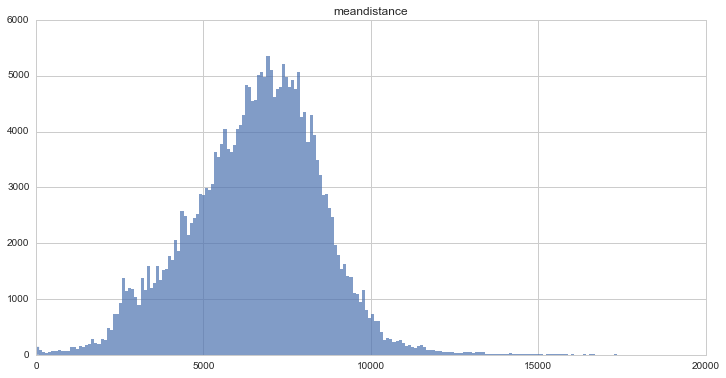

In [26]:
shipdata[shipdata['meandistance']>0].hist('meandistance', bins=200, lw=0, alpha=0.7,
                                          figsize=(12,6), )

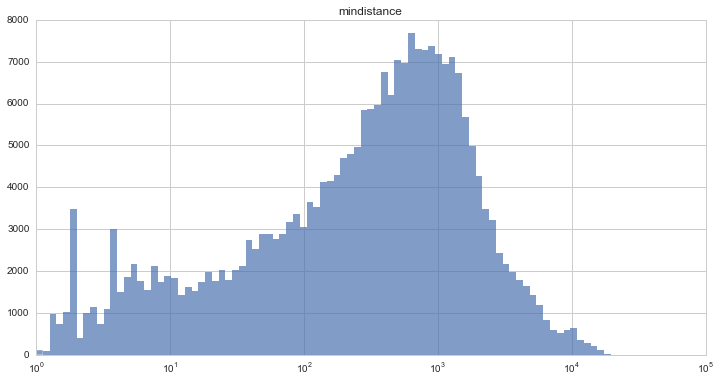

In [34]:
shipdata[shipdata['mindistance']>0].hist('mindistance', bins=np.logspace(0,5,100), lw=0, alpha=0.7,
                                          figsize=(12,6))
pylab.gca().set_xscale("log")

The not so lonely parts of the ocean

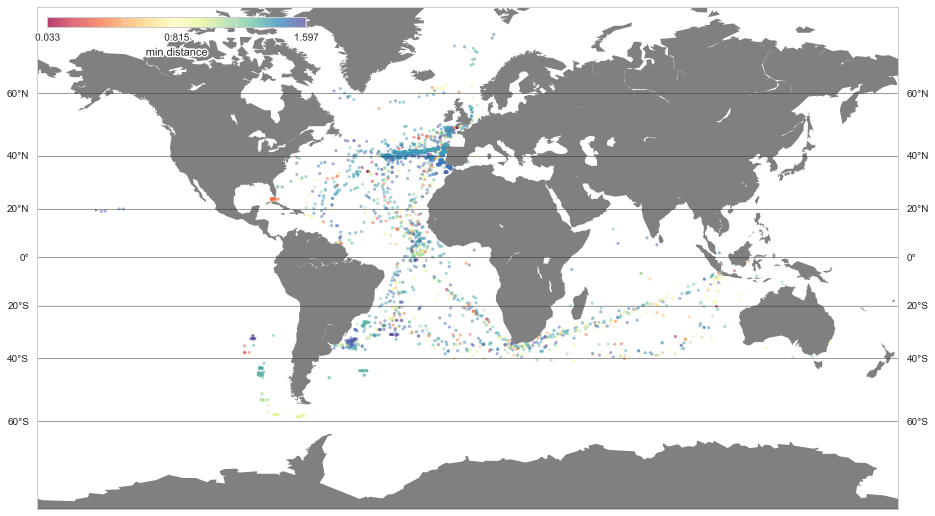

In [37]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)
# m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

x, y = m(lon, lat)
c = np.array(shipdata['mindistance'])
ii = np.where((c > 0) & (c < 1.6))[0] # 1 mile
sca = m.scatter(x[ii], y[ii], c=c[ii], label='min distance',
                cmap=pylab.cm.Spectral,
                s=10, lw=0, alpha=0.5)
icolorbar(sca)
None

# Nationality

American 195
British 84207
Danish 51
Dutch 113626
French 8229
Hamburg 65
Spanish 45949
Swedish 595


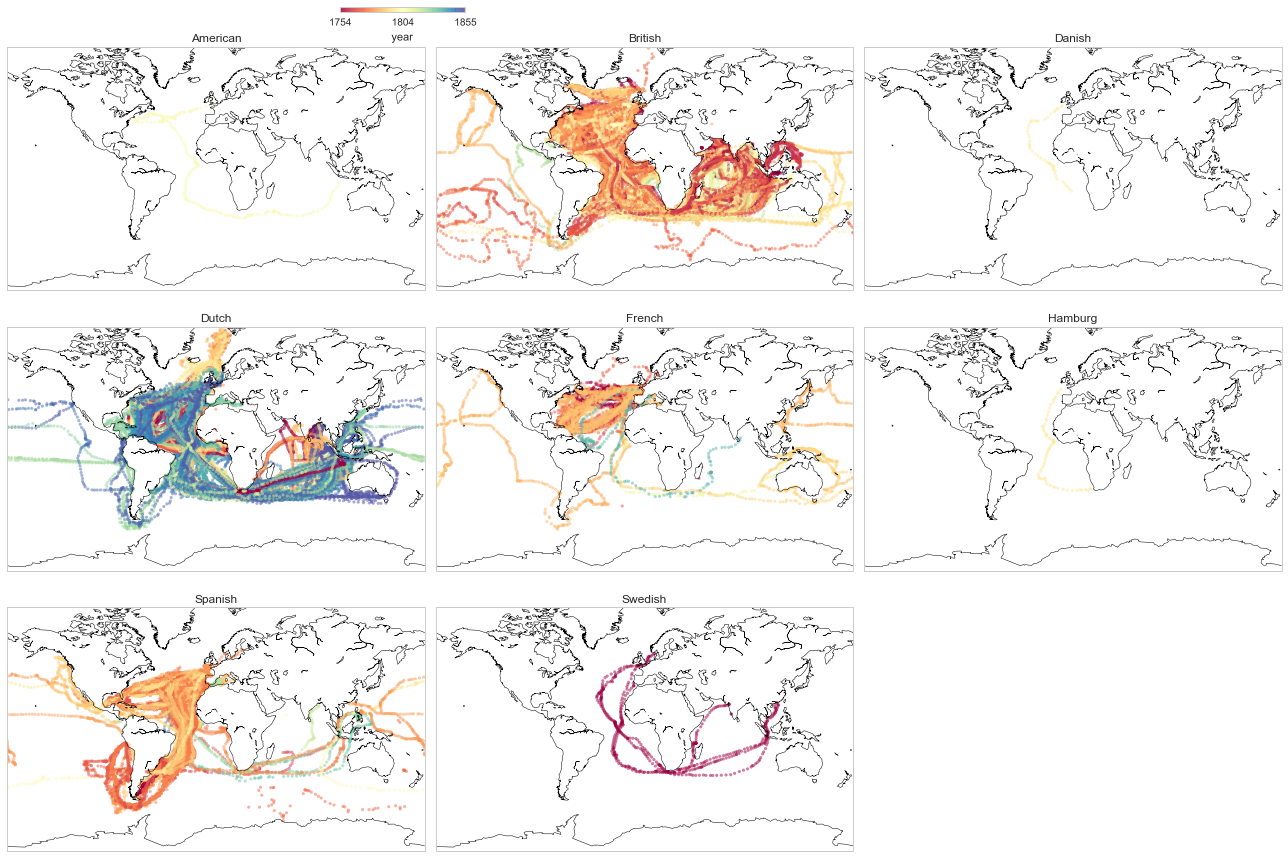

In [42]:
pylab.figure(figsize=(18,12))

x, y = m(lon, lat)
c = np.array(shipdata['Year'])
nationality = np.array(shipdata['nat'])
unat = np.unique(nationality)
for i, nat in enumerate(unat):
    pylab.subplot(3, 3, i+1)
    pylab.title(nat)
    m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                        urcrnrlon=180, urcrnrlat=80,
                        projection='mill')
#     m.fillcontinents(color='0.5')
    m.drawcoastlines(linewidth=0.5)
#     m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
    
    ii = np.where(nationality == nat)[0]
    print nat, len(ii)
    sca = m.scatter(x[ii], y[ii], c=c[ii], label='{} Year'.format(nat),
                    cmap=pylab.cm.Spectral, vmin=1754, vmax=1855,
                    s=10, lw=0, alpha=0.5)
    if nat == 'American':
        icolorbar(sca, label='year', loc=1, tickfmt='{:0.0f}', borderpad=-4)
#     break
pylab.tight_layout()

In [ ]:
bins = np.linspace(1754, 1855, 51)
# names, groups = zip(*[(name, group['Year']) for name, group in shipdata.groupby('nat')
#                       if name not in ['American', 'Danish', 'Hamburg', 'Swedish']])
# pylab.hist(groups, bins=bins, stacked=True, histtype='bar', label=names)
# legend()



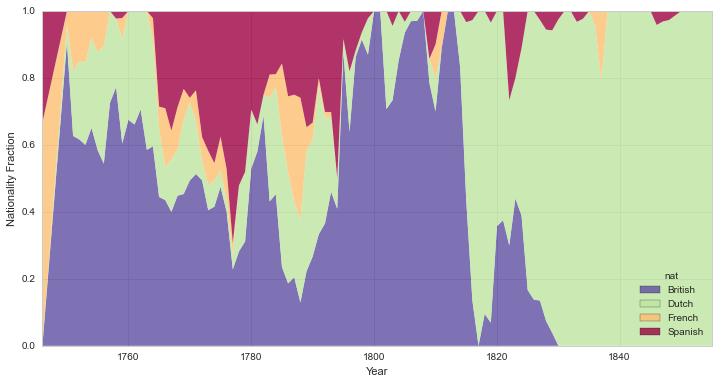

In [102]:
tmp = shipdata[['nat', 'Year', 'VoyageIni', 'ShipName']].drop_duplicates()
isgood = ( (tmp.Year > 1745) & 
           (tmp.nat != 'American') & 
           (tmp.nat != 'Danish') & 
           (tmp.nat != 'Hamburg') &
           (tmp.nat != 'Swedish') )
nat_yearly = tmp[isgood].groupby(['Year'])['nat'].value_counts().unstack(1).fillna(0)
norm_nat_yearly = nat_daily.div(nat_yearly.sum(axis=1), axis=0)
ax = norm_nat_yearly.plot(kind='Area', figsize=(12, 6), cmap=pylab.cm.Spectral_r, lw=0, alpha=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Nationality Fraction')


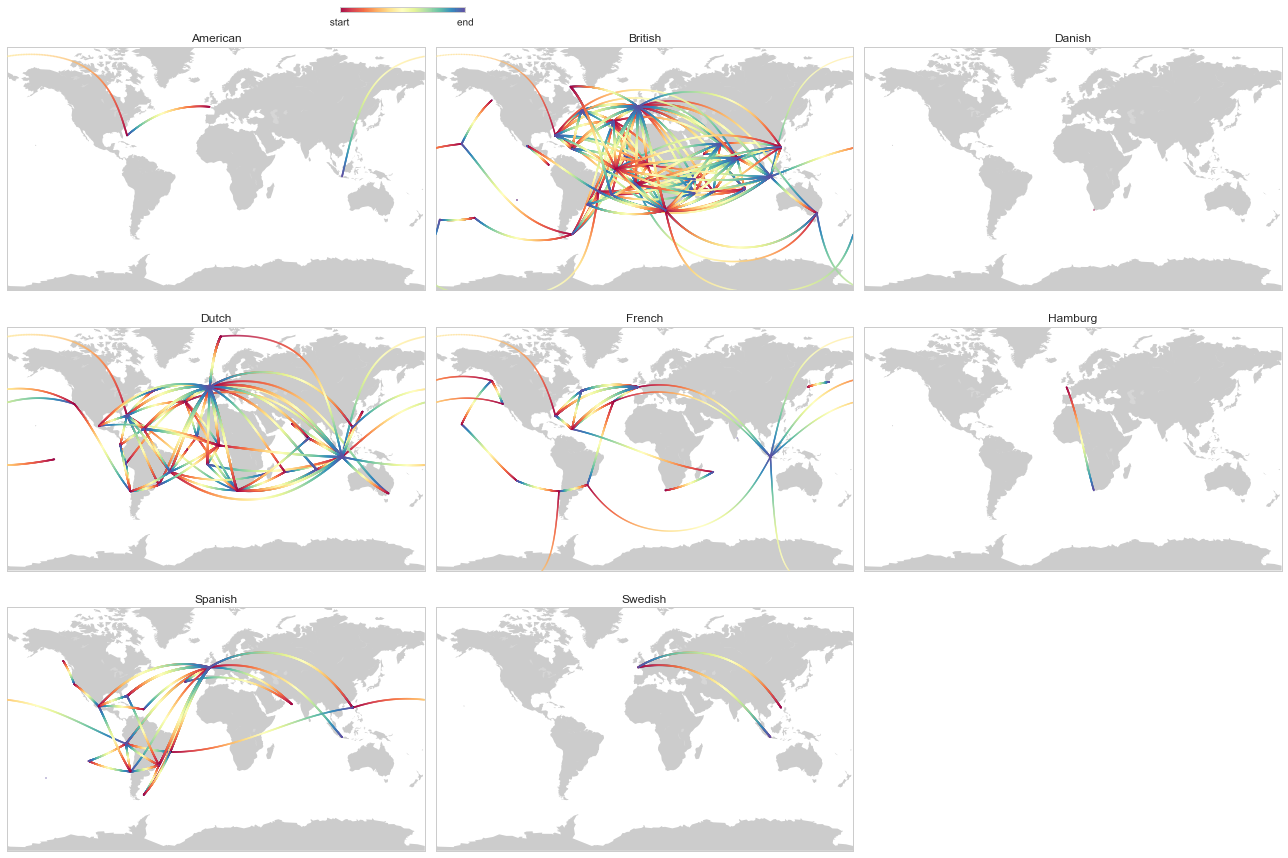

In [20]:
ngc = 500
pylab.figure(figsize=(18,12))

fromarr = shipdata['from_label'].astype('str')
ufrom = np.unique(fromarr)

nationality = np.array(shipdata['nat'])
unat = np.unique(nationality)
for i, nat in enumerate(unat):
    pylab.subplot(3, 3, i+1)
    pylab.title(nat)
    m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
    m.fillcontinents(color='k', alpha=0.2)
    
    
    for uf in ufrom:
        tmp = shipdata[(nationality == nat) & (fromarr == uf)]
        toarr = tmp['to_label'].astype('str')

        for ut in np.unique(toarr):
            tmp2 = tmp[(toarr == ut)]
            if len(tmp2) < 10:
                continue
            x,y = m.gcpoints(tmp2['from_lon'].iloc[0], tmp2['from_lat'].iloc[0], 
                             tmp2['to_lon'].iloc[0], tmp2['to_lat'].iloc[0], ngc)
            sca = m.scatter(x, y, c=np.linspace(0,1,ngc), 
                            alpha=0.7, lw=0, s=1+np.log10(len(tmp2)), #s=1+len(tmp2)*10.0/npts, 
                            cmap=pylab.cm.Spectral, vmin=0, vmax=1, zorder=4)
    
    if nat == 'American':
        icolorbar(sca, ticks=[0,1], ticknames=['start', 'end'], loc=1, borderpad=-4)
pylab.tight_layout()

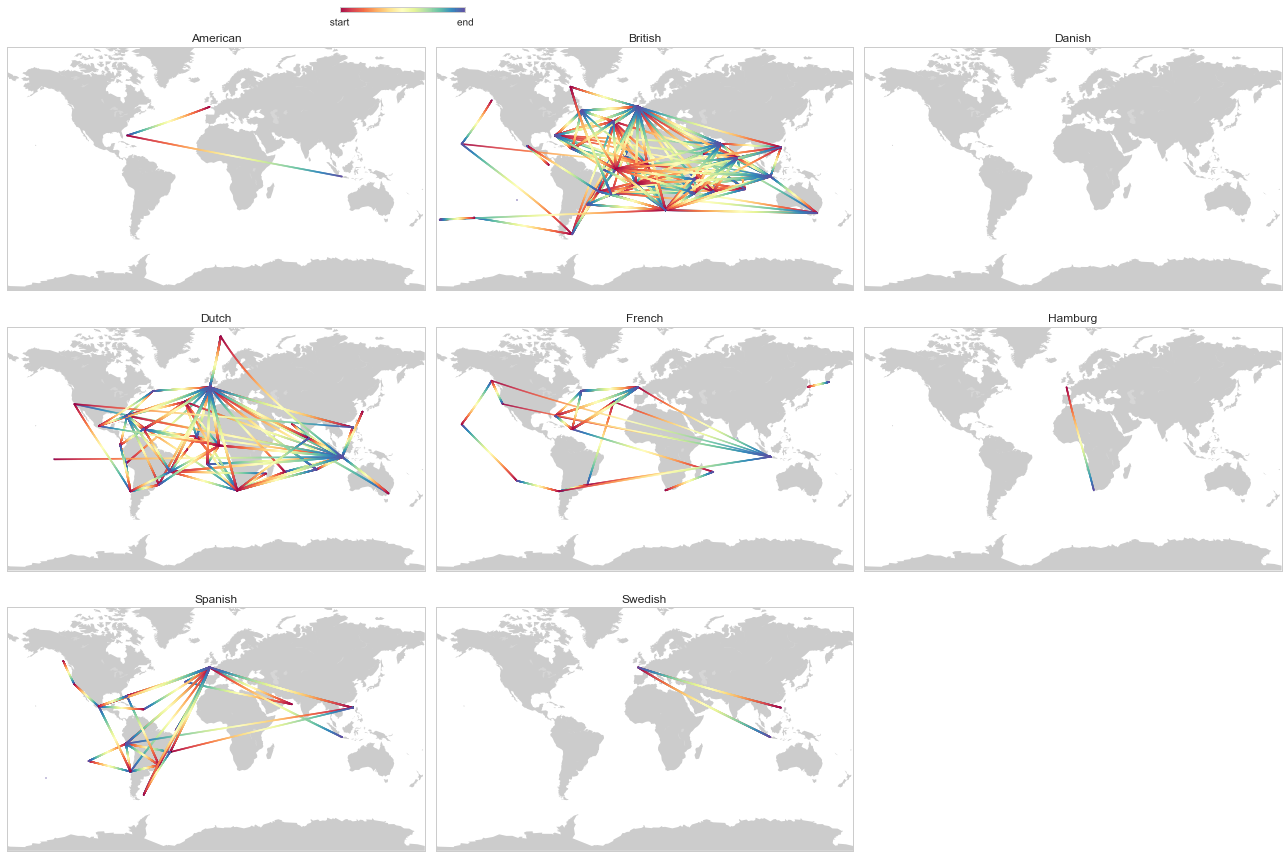

In [104]:
ngc = 500
pylab.figure(figsize=(18,12))

fromarr = shipdata['from_label'].astype('str')
ufrom = np.unique(fromarr)

nationality = np.array(shipdata['nat'])
unat = np.unique(nationality)
for i, nat in enumerate(unat):
    pylab.subplot(3, 3, i+1)
    pylab.title(nat)
    m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
    m.fillcontinents(color='k', alpha=0.2)
    
    
    for uf in ufrom:
        tmp = shipdata[(nationality == nat) & (fromarr == uf)]
        toarr = tmp['to_label'].astype('str')

        for ut in np.unique(toarr):
            tmp2 = tmp[(toarr == ut)]
            if len(tmp2) < 10:
                continue
            x = np.linspace(tmp2['from_lon'].iloc[0], tmp2['to_lon'].iloc[0], ngc)
            y = np.linspace(tmp2['from_lat'].iloc[0], tmp2['to_lat'].iloc[0], ngc)
            x,y = m(x,y)
            sca = m.scatter(x, y, c=np.linspace(0,1,ngc), 
                            alpha=0.7, lw=0, s=1+np.log10(len(tmp2)), #s=1+len(tmp2)*10.0/npts, 
                            cmap=pylab.cm.Spectral, vmin=0, vmax=1, zorder=4)
    
    if nat == 'American':
        icolorbar(sca, ticks=[0,1], ticknames=['start', 'end'], loc=1, borderpad=-4)
pylab.tight_layout()

In [24]:
import networkx as nx

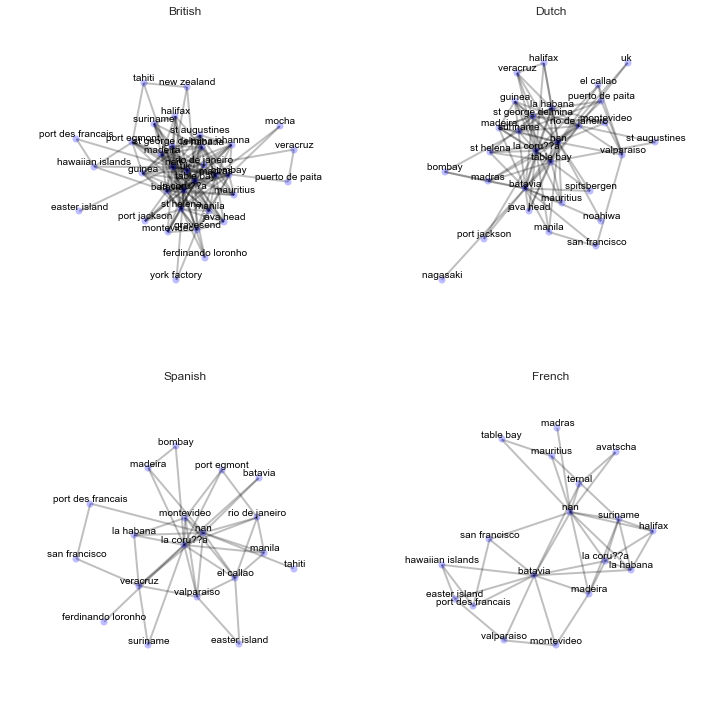

In [109]:
pylab.figure(figsize=(12,12))

nationality = np.array(shipdata['nat'])
unat = ['British', 'Dutch', 'Spanish', 'French']

fromarr = shipdata['from_label'].astype('str')
ufrom = np.unique(fromarr)
t = '     \n'

for i, nat in enumerate(unat):
    pylab.subplot(2, 2, i+1)
    pylab.title(nat)
    
    G = nx.Graph()
    for uf in ufrom:
        tmp = shipdata[(nationality == nat) & (fromarr == uf)]
        toarr = tmp['to_label'].astype('str')
        if len(toarr) <= 1:
            continue
        G.add_node(uf+t)
        for ut in np.unique(toarr):
            ii = np.where(toarr == ut)[0]
            G.add_node(ut+t)
            weight = (1+0*np.log10(len(ii)))
            G.add_edge(uf+t, ut+t, weight=weight)
#     pos = nx.spring_layout(G, scale=3 )
#     pos=nx.graphviz_layout(G,prog='twopi',args='')
#     nx.draw(G, pos, font_size=8, node_size=10, with_labels=True)
    nx.draw_spring(G, with_labels=True, font_size=10,
                   node_color='b', 
#                    node_color=np.random.rand(G.number_of_nodes()), cmap=pylab.cm.jet,
                   node_size=50, linewidths=0, width=2, alpha=0.25)

18